<font color="#CC3D3D"><p>
# Ensemble Learning

### Data Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read Data
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
cancer.data.shape, cancer.feature_names

((569, 30),
 array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
        'mean smoothness', 'mean compactness', 'mean concavity',
        'mean concave points', 'mean symmetry', 'mean fractal dimension',
        'radius error', 'texture error', 'perimeter error', 'area error',
        'smoothness error', 'compactness error', 'concavity error',
        'concave points error', 'symmetry error',
        'fractal dimension error', 'worst radius', 'worst texture',
        'worst perimeter', 'worst area', 'worst smoothness',
        'worst compactness', 'worst concavity', 'worst concave points',
        'worst symmetry', 'worst fractal dimension'], dtype='<U23'))

***유방암 진단 데이터***      
- 타겟 데이터: 종양이 악성(malignant, 0) or 양성(benign, 1)
- 속성 데이터: 유방암 진단 사진으로부터 측정한 종양(tumar)의 특징값(30 개)

In [3]:
# Split Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

## Correlation between models

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

LogisticRegression             0.9440559440559441
DecisionTreeClassifier         0.8811188811188811
MLPClassifier                  0.9300699300699301
KNeighborsClassifier           0.9370629370629371
RandomForestClassifier         0.972027972027972
GradientBoostingClassifier     0.965034965034965


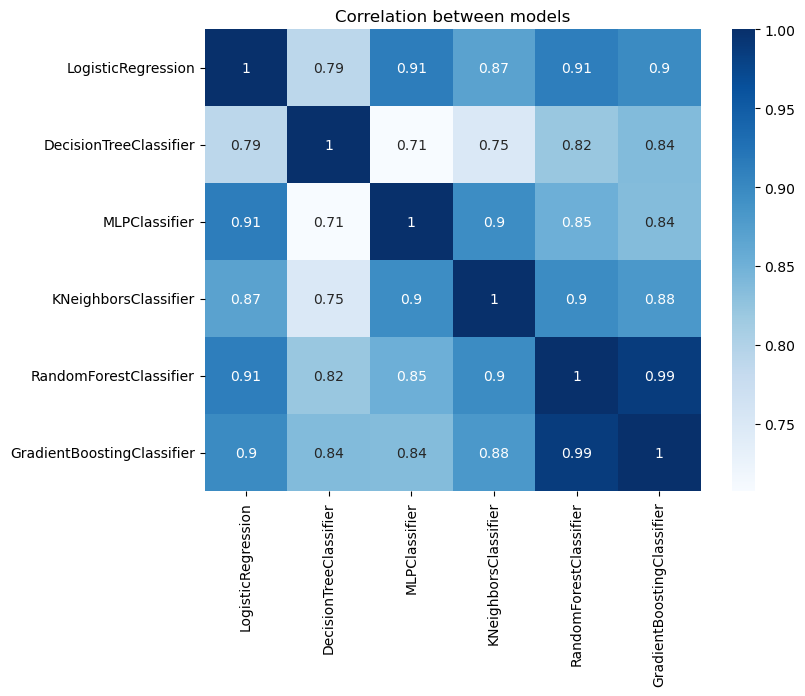

In [5]:
clfs = []
LR=LogisticRegression(random_state=0); clfs.append(LR)
DT=DecisionTreeClassifier(random_state=0); clfs.append(DT)
MLP=MLPClassifier(random_state=0); clfs.append(MLP)
KNN=KNeighborsClassifier(); clfs.append(KNN)
RF=RandomForestClassifier(random_state=0); clfs.append(RF)
GBM=GradientBoostingClassifier(random_state=0); clfs.append(GBM)

pred_results = []
for clf in clfs :
    pred = clf.fit(X_train, y_train).predict(X_test)
    name = type(clf).__name__
    pred_results.append(pd.Series(pred, name=name))
    print("{:30s} {}".format(name, accuracy_score(y_test, pred)))

ensemble_results = pd.concat(pred_results, axis=1)
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(),annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

In [6]:
ensemble_results

,LogisticRegression,DecisionTreeClassifier,MLPClassifier,KNeighborsClassifier,RandomForestClassifier,GradientBoostingClassifier
0,0,0,0,0,0,0
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,0,0,1,1
4,1,1,1,1,1,1
...,...,...,...,...,...,...
138,0,0,0,0,0,0
139,1,1,1,1,1,1
140,1,1,1,1,1,1
141,1,1,1,1,1,1


## Voting ensemble   
*평가지표가 accuracy, recall, precision 등일 경우 사용*

In [7]:
from sklearn.ensemble import VotingClassifier

# 위에서 평가한 모든 모델을 앙상블할 경우
voting = VotingClassifier(
    estimators = [(type(clf).__name__, clf) for clf in clfs], voting='hard')
voting.fit(X_train, y_train).score(X_test, y_test)

0.958041958041958

In [8]:
# 가장 성능이 높은 GBM과 낮은 상관관계가 있는 모델끼리만 앙상블할 경우
voting = VotingClassifier(
    estimators = [('gbm', GBM), ('mlp', MLP), ('dt', DT)], voting='hard')
voting.fit(X_train, y_train).score(X_test, y_test)

0.958041958041958

In [9]:
# GBM과 성능이 비슷한 LR과 낮은 상관관계가 있는 모델끼리만 앙상블할 경우
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(
    estimators = [('lr', LR), ('dt', DT), ('knn', KNN)], voting='hard')
voting.fit(X_train, y_train).score(X_test, y_test)

0.951048951048951

***Plotting Decision Regions***

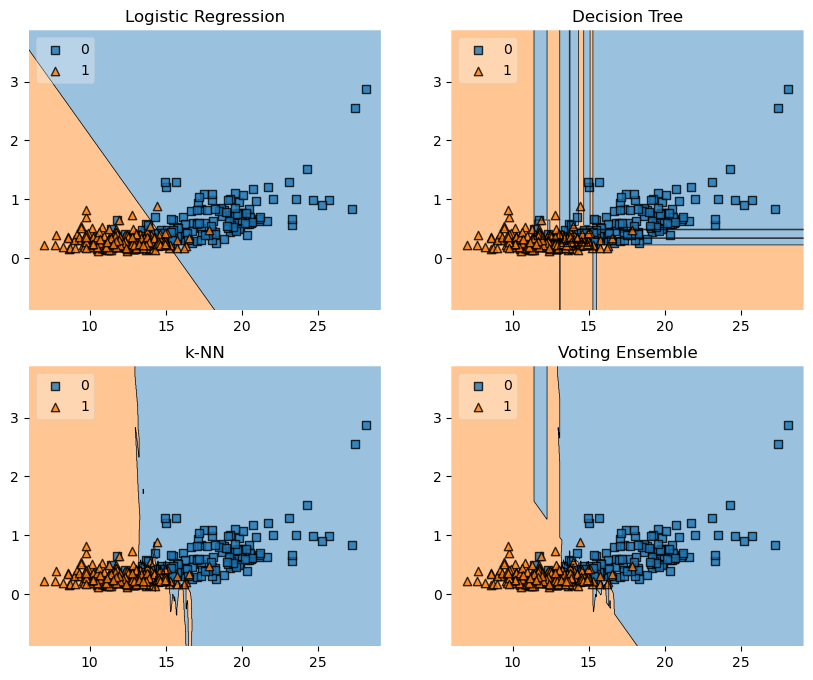

In [10]:
import matplotlib.gridspec as gridspec
import itertools
from mlxtend.plotting import plot_decision_regions

X, y = X_train, y_train
X = X[:,[0, 10]]

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

labels = ['Logistic Regression',
          'Decision Tree',
          'k-NN',
          'Voting Ensemble']

for clf, lab, grd in zip([LR, DT, KNN, voting],
                         labels,
                         itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)

plt.show()

## Averaging predictions   
*평가지표가 roc-auc, logloss 등일 경우 사용*

***Arithmetic mean***

In [11]:
averaging = VotingClassifier(
    estimators = [('lr', LR), ('dt', DT), ('knn', KNN)], voting='soft')
averaging.fit(X_train, y_train)

print('AUC =', roc_auc_score(y_test, averaging.predict_proba(X_test)[:,1]))

AUC = 0.9878406708595389


<img align='left' src="https://t1.daumcdn.net/cfile/tistory/2454233C57FA242D11">

***Geometric mean***

In [12]:
from scipy.stats.mstats import gmean

pred_logreg = LR.fit(X_train, y_train).predict_proba(X_test)[:,1]
pred_tree = DT.fit(X_train, y_train).predict_proba(X_test)[:,1]
pred_knn = KNN.fit(X_train, y_train).predict_proba(X_test)[:,1]

print('AUC = ', roc_auc_score(y_test, gmean([pred_logreg, pred_tree, pred_knn], axis=0)))

AUC =  0.9157232704402516


## Stacking 
<br>
<img align='left' src="https://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier_files/stackingclassification_overview.png" width=500 height=400>

Install **vecstack** package using the following command:
```
!pip install vecstack
```
https://github.com/vecxoz/vecstack#variant-a-animation    


    
    
***2-layer stacking***

In [15]:
from vecstack import stacking

models = clfs
S_train, S_test = stacking(models,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=False,           # classification task (if you need 
                                                       #     regression - set to True)
                           needs_proba=False,          # predict class labels (if you need 
                                                       #     probabilities - set to True) 
                           metric=accuracy_score,      # metric: callable
                           n_folds=5,                  # number of folds
                           stratified=True,            # stratified split for folds
                           shuffle=True,               # shuffle the data
                           random_state=0,             # ensure reproducibility
                           verbose=2)                  # print all info
meta_model = GBM.fit(S_train, y_train)
accuracy_score(y_test, meta_model.predict(S_test))

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [6]

model  0:     [LogisticRegression]
    fold  0:  [0.91860465]
    fold  1:  [0.94117647]
    fold  2:  [0.96470588]
    fold  3:  [0.98823529]
    fold  4:  [0.95294118]
    ----
    MEAN:     [0.95313269] + [0.02324351]
    FULL:     [0.95305164]

model  1:     [DecisionTreeClassifier]
    fold  0:  [0.93023256]
    fold  1:  [0.90588235]
    fold  2:  [0.94117647]
    fold  3:  [0.91764706]
    fold  4:  [0.91764706]
    ----
    MEAN:     [0.92251710] + [0.01209835]
    FULL:     [0.92253521]

model  2:     [MLPClassifier]
    fold  0:  [0.93023256]
    fold  1:  [0.92941176]
    fold  2:  [0.92941176]
    fold  3:  [0.97647059]
    fold  4:  [0.90588235]
    ----
    MEAN:     [0.93428181] + [0.02302283]
    FULL:     [0.93427230]

model  3:     [KNeighborsClassifier]
    fold  0:  [0.89534884]
    fold  1:  [0.95294118]
    fold  2:  [0.94117647]
    fold

0.958041958041958

In [16]:
X_train.shape, S_train.shape, X_test.shape, S_test.shape

((426, 30), (426, 6), (143, 30), (143, 6))

***3-layer stacking***

In [17]:
# level-1: LR, DT, MLP, KNN, RF, GBM

models = clfs
S_train, S_test = stacking(models,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=False,           # classification task (if you need 
                                                       #     regression - set to True)
                           needs_proba=True,           # predict class labels (if you need 
                                                       #     probabilities - set to True) 
                           metric=accuracy_score,      # metric: callable
                           n_folds=3,                  # number of folds
                           stratified=True,            # stratified split for folds
                           shuffle=True,               # shuffle the data
                           random_state=0,             # ensure reproducibility
                           verbose=0)                  # print all info

In [18]:
# level-2: LR, DT, KNN
# Level-3: Voting

voting = VotingClassifier(estimators = [('lr', LR), ('dt', DT), ('knn', KNN)], voting='hard')
voting.fit(S_train, y_train).score(S_test, y_test)

0.986013986013986

***using `sklearn`***

In [19]:
from sklearn.ensemble import StackingClassifier

# 2-layer stacking

estimators = [(type(clf).__name__, clf) for clf in clfs]
stk_clf = StackingClassifier(
    estimators=estimators, final_estimator=GBM, cv=5)

stk_clf.fit(X_train, y_train).score(X_test, y_test)

0.972027972027972

In [20]:
# 3-layer stacking (Level-3: Voting)

layer_one_estimators = [(type(clf).__name__, clf) for clf in clfs]
voting = VotingClassifier(estimators = [('lr', LR), ('dt', DT), ('knn', KNN)], voting='hard')
stk_clf = StackingClassifier(estimators=layer_one_estimators, final_estimator=voting, cv=5)

stk_clf.fit(X_train, y_train).score(X_test, y_test)

0.965034965034965

In [21]:
# 3-layer stacking (Level-3: LR)

layer_one_estimators = [(type(clf).__name__, clf) for clf in clfs]
layer_two_estimators = [('lr', LR), ('dt', DT), ('knn', KNN)]

layer_two = StackingClassifier(estimators=layer_two_estimators, final_estimator=LR)
stk_clf = StackingClassifier(estimators=layer_one_estimators, final_estimator=layer_two, cv=5)

stk_clf.fit(X_train, y_train).score(X_test, y_test)

0.965034965034965

##### Improvements in stacked model performance can be accomplished by:
- Adding models to Level 0 and Level 1 using different algorithms
- Tuning Hyper-parameters
- Adding feature sets by feature engineering
- Adding levels in the model structure

### Model Stacking in Kaggle: 
- [1st Place Solution of "Home Depot Product Search Relevance"](https://github.com/ChenglongChen/Kaggle_HomeDepot)
<img src="https://github.com/ChenglongChen/Kaggle_HomeDepot/raw/master/Fig/FlowChart.jpg" width=800, height=600><p>
- [1st Place Solution of "Otto Group Product Classification Challenge"](https://www.kaggle.com/c/otto-group-product-classification-challenge/discussion/14335)
<br>
<img src="http://drive.google.com/uc?export=view&id=1SfVsQSX7Rjmu335zX1aFdolBKccv545w" width=600, height=400>
<br><br>
- [1st Place Solution of "Homesite Quote Conversion"](https://kweonwooj.tistory.com/2)
<br>
<img src="https://t1.daumcdn.net/cfile/tistory/2132EF50571DDC1F26" width=700, height=500>
<br><br>

<font color="#CC3D3D"><p>
# End